In [ ]:
# ! gsutil -m rsync -r gs://tesorai-data/nature_methods_submission/for_pride ../data/benchmark_results

In [1]:
import pandas as pd

import upsetplot
from upsetplot import UpSet

import sys
import os

# silence warnings
import warnings

warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
from tesorai_search import data_parsing_utils

In [7]:
_DATA_DIR = "../data/benchmark_results/"
benchmark = "bassani_sternberg"
# benchmark = "bekker_jensen"

benchmark_results = {
    "Tesorai": set(
        data_parsing_utils.get_tesorai_peptides(
            _DATA_DIR + f"{benchmark}/tesorai/pep_fdr.csv"
        )
    ),
    "MaxQuant": set(
        data_parsing_utils.get_maxquant_peptides(
            _DATA_DIR + f"{benchmark}/maxquant/msms.txt"
        )
    ),
    "FragPipe": set(
        data_parsing_utils.get_fragpipe_peptides(
            _DATA_DIR + f"{benchmark}/fragpipe/peptides.tsv"
        )
    ),
    "Peaks": set(
        data_parsing_utils.get_peaks_peptides(
            _DATA_DIR + f"{benchmark}/peaks/peptides.csv"
        )
    ),
    "Proteome Discoverer": set(
        data_parsing_utils.get_pd_peptides(
            _DATA_DIR + f"{benchmark}/proteome_discoverer/peptides.xlsx"
        )
    ),
}

Found 47393 peptides by TS
Found 22166 peptides by maxquant from 182392 unique rows
Found 39410 peptides by fragpipe from 39410 unique rows
Found 44396 peptides by PEAKS from 49774 unique rows
Found 35882 peptides by PD from 37941 unique rows


<Figure size 1000x600 with 0 Axes>

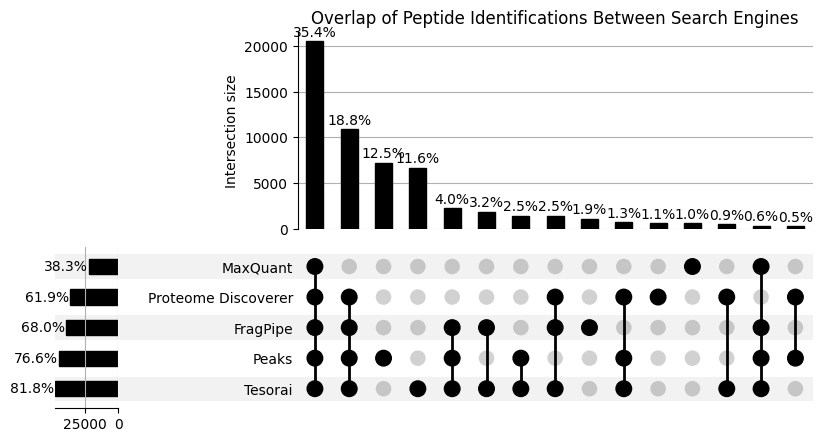

In [8]:
from_contents = upsetplot.from_contents(benchmark_results)

# Create and customize the plot
fig = plt.figure(figsize=(10, 6))
upset = UpSet(
    from_contents,
    sort_by="cardinality",
    show_percentages=True,
    min_subset_size=300,
)
upset.plot()
plt.title("Overlap of Peptide Identifications Between Search Engines")
plt.show()

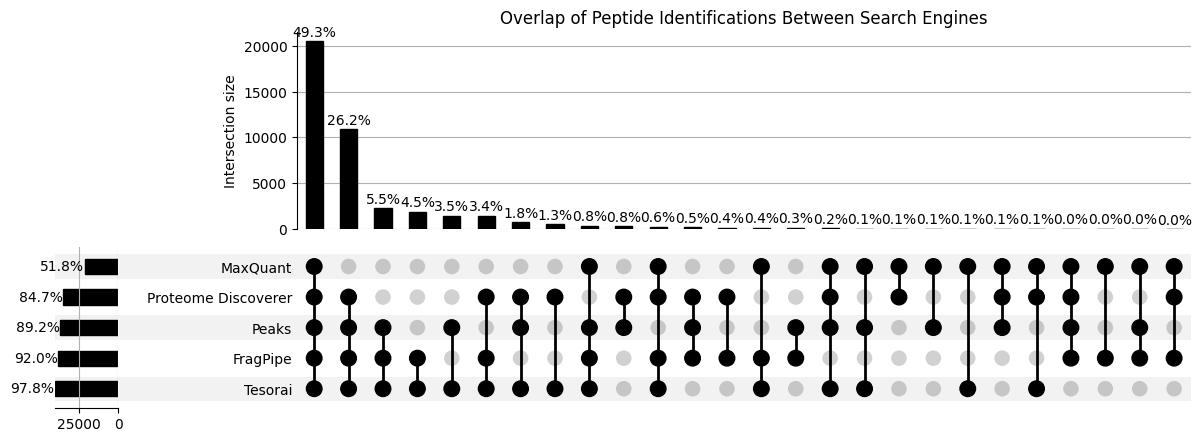

In [9]:
benchmark_results_robust = {}

for search_engine, peptides in benchmark_results.items():
    union_others = set()
    for other_engine, other_peptides in benchmark_results.items():
        if other_engine != search_engine:
            union_others.update(other_peptides)
    # Intersect with the union of all other search engines' peptides
    benchmark_results_robust[search_engine] = peptides.intersection(union_others)

from_contents = upsetplot.from_contents(benchmark_results_robust)

# Create upset plot after removing all entries that are unique to only one search engine
upset = UpSet(
    from_contents,
    sort_by="cardinality",
    show_percentages=True,
    # min_subset_size=300,
)
upset.plot()
plt.title("Overlap of Peptide Identifications Between Search Engines")
plt.show()